<a href="https://colab.research.google.com/github/czeacach/fashion_designers/blob/main/Analyse_genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des spécificités des genres
Dans ce carnet est proposée une analyse des spécificités des genres, en relation avec le temps et la région d'origine.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [3]:
!pip install fanalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 745.0 kB/s eta 0:00:00


In [4]:
from fanalysis.ca import CA
from fanalysis.mca import MCA

## Importer les données à analyser

In [5]:
# Chemin de la base de données dans Google Drive
db_path = "/content/drive/MyDrive/dossier de travail/fashion_designers_data_analysis.db"

# Connexion à la base de données SQLite
cn = sql.connect(db_path)
cn

In [6]:
### Créer la requête SQL et inspecter le résultat
# Noter les jointures entre les différentes tables
qr = """


SELECT wp.personUri, wp.personLabel,
   CASE
       WHEN wp.genderUri = 'http://www.wikidata.org/entity/Q6581097' THEN 'M'
       WHEN wp.genderUri = 'http://www.wikidata.org/entity/Q6581072' THEN 'F'
       ELSE 'A'
   END AS gender,
   max(wp.birthYear) AS birthYear,
   max(
       CASE
           WHEN wc.continentLabel = 'Europe' THEN er.europe_regionLabel
           ELSE wc.continentLabel
       END
   ) AS region_label
FROM
    wdt_person_nationality wpo
JOIN
    wdt_personne wp ON wp.personUri = wpo.personUri
JOIN
    wdt_nationality wn ON wpo.nationalityUri = wn.nationalityUri
JOIN
    continents wc ON wn.fk_continent = wc.pk_continent
LEFT JOIN
    europe_regions er ON er.pk_europe_region = wn.fk_europe_region
GROUP BY
    wp.personUri, wp.personLabel;
 """

In [7]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

2856


[('http://www.wikidata.org/entity/Q100324415',
  'Estrella Rivas Franco',
  'F',
  '1921',
  'southern_europe'),
 ('http://www.wikidata.org/entity/Q100462257',
  'Ina Trifonova',
  'F',
  '1981',
  'eastern_europe'),
 ('http://www.wikidata.org/entity/Q101085725',
  'Abbas Kaijuka',
  'M',
  '1989',
  'Africa')]

In [8]:
### Créer un DataFrame contenant les données
df_orig = pd.DataFrame(l, columns=['uri', 'nom', 'gender', 'annee_nais',
                     'origines_geog'])
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2856 entries, 0 to 2855
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   uri            2856 non-null   object
 1   nom            2856 non-null   object
 2   gender         2856 non-null   object
 3   annee_nais     2856 non-null   object
 4   origines_geog  2855 non-null   object
dtypes: object(5)
memory usage: 111.7+ KB


In [9]:
### Distribution des genres
df_orig.groupby(by='gender').size().sort_values(ascending=False)

gender
F    1586
M    1254
A      16
dtype: int64

## Codage par périodes de cinquante ans

In [10]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_orig['annee_nais'] = df_orig['annee_nais'].astype(int)

In [11]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias)
cdf_p = df_orig[df_orig['annee_nais'] < 2002].copy(deep=True)
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog
0,http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,F,1921,southern_europe
1,http://www.wikidata.org/entity/Q100462257,Ina Trifonova,F,1981,eastern_europe
2,http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,M,1989,Africa


In [12]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1801, 2000)

In [13]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue,
# elle donc doit être supérieure à la valeur maximale
l_50 = list(range(1801, 2002, 50))
print(l_50)

[1801, 1851, 1901, 1951, 2001]


In [14]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_50, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,gender,annee_nais,origines_geog,periodes
0,http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,F,1921,southern_europe,1901-1950
1,http://www.wikidata.org/entity/Q100462257,Ina Trifonova,F,1981,eastern_europe,1951-2000
2,http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,M,1989,Africa,1951-2000


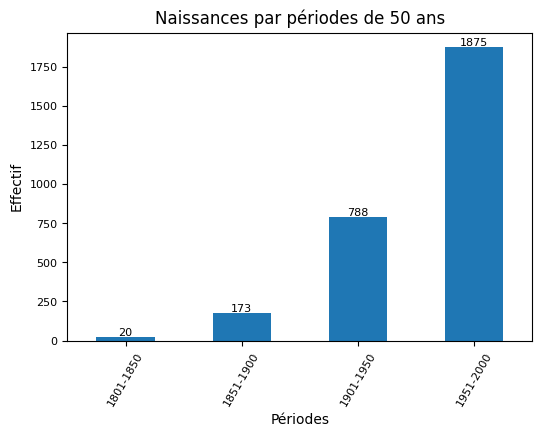

In [15]:
ax = cdf_p.groupby(by='periodes', observed=True).size()\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))

ax.bar_label(ax.containers[0], fontsize=8)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de 50 ans')
plt.show()

## Distributions des genres par périodes

In [16]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "gender"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

periodes,1801-1850,1851-1900,1901-1950,1951-2000,Total
gender,,,,,
A,0,0,2,14,16
F,9,119,413,1045,1586
M,11,54,373,816,1254
Total,20,173,788,1875,2856


**Commentaire**

Le tableau de contingence montre que une analyse quantitative est possible seulement à partir de 1851 et à l'exclusion du genre A='autres'.

In [17]:
### Création d'un tableau de données pour une analyse quantitative
cdf_cont = cdf_p[(cdf_p.annee_nais > 1850) \
                 & (cdf_p.gender != 'A')].copy(deep=True)
cdf_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 0 to 2855
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   uri            2820 non-null   object  
 1   nom            2820 non-null   object  
 2   gender         2820 non-null   object  
 3   annee_nais     2820 non-null   int64   
 4   origines_geog  2819 non-null   object  
 5   periodes       2820 non-null   category
dtypes: category(1), int64(1), object(4)
memory usage: 135.1+ KB


In [18]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue,
# elle donc doit être supérieure à la valeur maximale
l_25 = list(range(1851, 2002, 25))
l_25[:5],l_25[-5:]

([1851, 1876, 1901, 1926, 1951], [1901, 1926, 1951, 1976, 2001])

In [19]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_cont['period_25'] = pd.cut(cdf_cont['annee_nais'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_cont['period_25'] = cdf_cont['period_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_cont.head(3)

,uri,nom,gender,annee_nais,origines_geog,periodes,period_25
0,http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,F,1921,southern_europe,1901-1950,1901-1925
1,http://www.wikidata.org/entity/Q100462257,Ina Trifonova,F,1981,eastern_europe,1951-2000,1976-2000
2,http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,M,1989,Africa,1951-2000,1976-2000


In [20]:
### Tableau de contingence
X = "period_25"  # "0"
Y = "gender"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

period_25,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,1976-2000,Total
gender,,,,,,,
F,34,85,160,253,525,520,1577
M,8,46,107,266,482,334,1243
Total,42,131,267,519,1007,854,2820


In [21]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

period_25,1851-1875,1876-1900,1901-1925,1926-1950,1951-1975,1976-2000
gender,,,,,,
F,34,85,160,253,525,520
M,8,46,107,266,482,334


In [22]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 6 ), effectif: 2820 , nombre max. facteurs: 1


In [23]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)


Chi2 : 41.92813744121829 , dof : 5
p-value : 6.090968066344599e-08
phi2 = inertie (variance totale) : 0.014868133844403648
Cramer:  0.12193495743388623


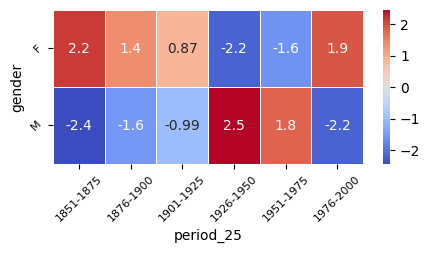

In [24]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(5,2))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

plt.show()

**Commentaire**

( A indiquer)
Comme la variable 'gender' a deux modalités un seul facteur résumé la variance et une analyse factorielle n'est pas utile.

## Distributions des genres par origines

In [25]:
### Tableau de contingence
X = "gender"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

gender,F,M,Total
origines_geog,,,
Africa,62,41,103
Asia,198,189,387
North America,305,232,537
Oceania,60,19,79
South America,81,87,168
eastern_europe,84,32,116
northern_europe,294,185,479
southern_europe,155,174,329
western_europe,337,284,621


In [26]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

gender,F,M
origines_geog,,
Africa,62,41
Asia,198,189
North America,305,232
Oceania,60,19
South America,81,87
eastern_europe,84,32
northern_europe,294,185
southern_europe,155,174
western_europe,337,284


In [27]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 9 , 2 ), effectif: 2819 , nombre max. facteurs: 1


In [28]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 51.017598329479725 , dof : 8
p-value : 2.6036628394747202e-08
phi2 = inertie (variance totale) : 0.018097764572358895
Cramer:  0.13452793231280594


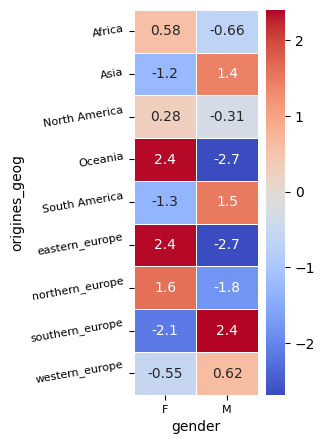

In [29]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(2,5))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes,
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=0, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=10, fontsize=8)



plt.show()

**Commentaire**

On observe que les femmmes sont plus présentes en Europe de l'Est du Nord et en Océanie.Les hommes sont quant à eux plus présents en Europe du Sud, en Amérique du Sud et en Asie.

Les différences de réprésentation en Amérique du Nord et en Europe de l'Ouest sont faibles.

## Analyser le lien entre genre+période et l'aire géographique

Cette analyse plus fine permet de comparer trois variable mais dans une logique bivariée

In [30]:
cdf_cont.period_25 = cdf_cont.period_25.astype("str")
cdf_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 0 to 2855
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   uri            2820 non-null   object  
 1   nom            2820 non-null   object  
 2   gender         2820 non-null   object  
 3   annee_nais     2820 non-null   int64   
 4   origines_geog  2819 non-null   object  
 5   periodes       2820 non-null   category
 6   period_25      2820 non-null   object  
dtypes: category(1), int64(1), object(5)
memory usage: 157.2+ KB


In [31]:
cdf_cont['gender_period_25'] = cdf_cont.apply(lambda x: \
                    x.period_25 + '_' + x.gender, axis=1)
cdf_cont.head()

,uri,nom,gender,annee_nais,origines_geog,periodes,period_25,gender_period_25
0,http://www.wikidata.org/entity/Q100324415,Estrella Rivas Franco,F,1921,southern_europe,1901-1950,1901-1925,1901-1925_F
1,http://www.wikidata.org/entity/Q100462257,Ina Trifonova,F,1981,eastern_europe,1951-2000,1976-2000,1976-2000_F
2,http://www.wikidata.org/entity/Q101085725,Abbas Kaijuka,M,1989,Africa,1951-2000,1976-2000,1976-2000_M
3,http://www.wikidata.org/entity/Q101611457,Dennis Klaverweide,M,1990,western_europe,1951-2000,1976-2000,1976-2000_M
4,http://www.wikidata.org/entity/Q101627961,Sepehr Maghsoudi,M,1982,western_europe,1951-2000,1976-2000,1976-2000_M


In [32]:
cdf_cont.groupby(by='gender_period_25').size()

gender_period_25
1851-1875_F     34
1851-1875_M      8
1876-1900_F     85
1876-1900_M     46
1901-1925_F    160
1901-1925_M    107
1926-1950_F    253
1926-1950_M    266
1951-1975_F    525
1951-1975_M    482
1976-2000_F    520
1976-2000_M    334
dtype: int64

In [33]:
### Tableau de contingence
X = "gender_period_25"
Y = "origines_geog"

ddf = cdf_cont[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

gender_period_25,1851-1875_F,1851-1875_M,1876-1900_F,1876-1900_M,1901-1925_F,1901-1925_M,1926-1950_F,1926-1950_M,1951-1975_F,1951-1975_M,1976-2000_F,1976-2000_M,Total
origines_geog,,,,,,,,,,,,,
Africa,0,0,0,0,1,1,3,2,13,11,45,27,103
Asia,0,0,1,1,12,4,37,36,70,83,78,65,387
North America,1,1,28,6,39,24,34,49,89,92,114,60,537
Oceania,1,0,1,0,8,1,10,6,26,8,14,4,79
South America,0,0,1,1,8,9,11,15,27,41,34,21,168
eastern_europe,0,0,4,1,6,3,11,6,24,8,39,14,116
northern_europe,8,0,7,0,24,16,57,49,115,79,83,41,479
southern_europe,3,0,8,13,27,21,25,53,43,66,49,21,329
western_europe,21,7,35,24,35,28,65,50,118,94,63,81,621


NB : comme l'Afrique et l'Océanie ont des effectifs limités ils risquent de biaiser l'analyse. Nous ne les ajoutons pas aux données à analyser.

Puisque les effectifs généraux sont très réduits jusqu'à 1901, et qu'ils risquent de baiser l'analyse quantitative, nous réduisons la période analyse au 20e siècle (1901 à 2000)

In [34]:
### Liste construite manuellement à partir de cette liste
# print(ddf.index.to_list())

li = ['Asia', 'North America',
       'South America', 'eastern_europe',
       'northern_europe', 'southern_europe', 'western_europe']

In [35]:
lc = ddf.columns.to_list()[:-1]

In [36]:
D = ddf.loc[li, lc].iloc[0:8, 5:12].copy(deep=True)
D

gender_period_25,1901-1925_M,1926-1950_F,1926-1950_M,1951-1975_F,1951-1975_M,1976-2000_F,1976-2000_M
origines_geog,,,,,,,
Asia,4,37,36,70,83,78,65
North America,24,34,49,89,92,114,60
South America,9,11,15,27,41,34,21
eastern_europe,3,11,6,24,8,39,14
northern_europe,16,57,49,115,79,83,41
southern_europe,21,25,53,43,66,49,21
western_europe,28,65,50,118,94,63,81


In [37]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 7 , 7 ), effectif: 2315 , nombre max. facteurs: 6


In [38]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 137.14490512204353 , dof : 36
p-value : 1.0090996382436501e-13
phi2 = inertie (variance totale) : 0.05924185966394969
Cramer:  0.09936620792465085


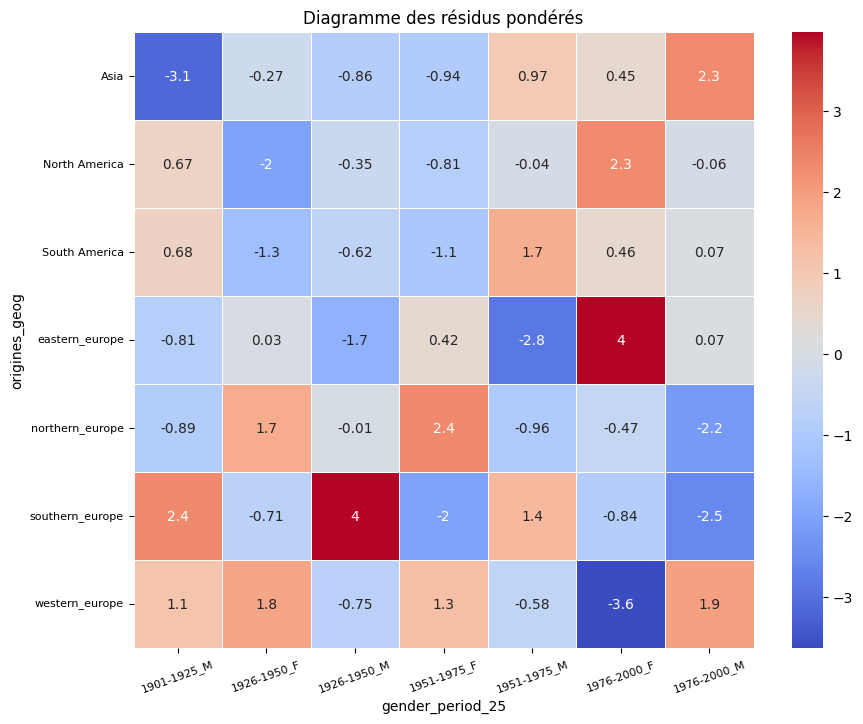

In [39]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(10,8))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes,
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=20, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=0, fontsize=8)


g.set_title('Diagramme des résidus pondérés')

plt.show()

In [40]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1901-1925_M', '1926-1950_F', '1926-1950_M', '1951-1975_F',
       '1951-1975_M', '1976-2000_F', '1976-2000_M'],
      dtype='object', name='gender_period_25'),
   row_labels=Index(['Asia', 'North America', 'South America', 'eastern_europe',
       'northern_europe', 'southern_europe', 'western_europe'],
      dtype='object', name='origines_geog'))

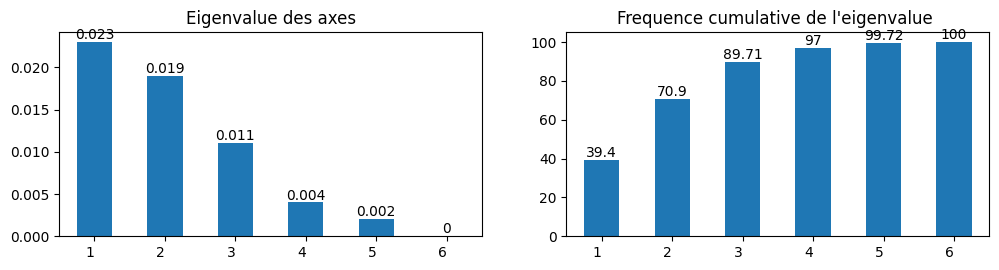

In [41]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()


## Graphiques et interprétation du premier plan factoriel

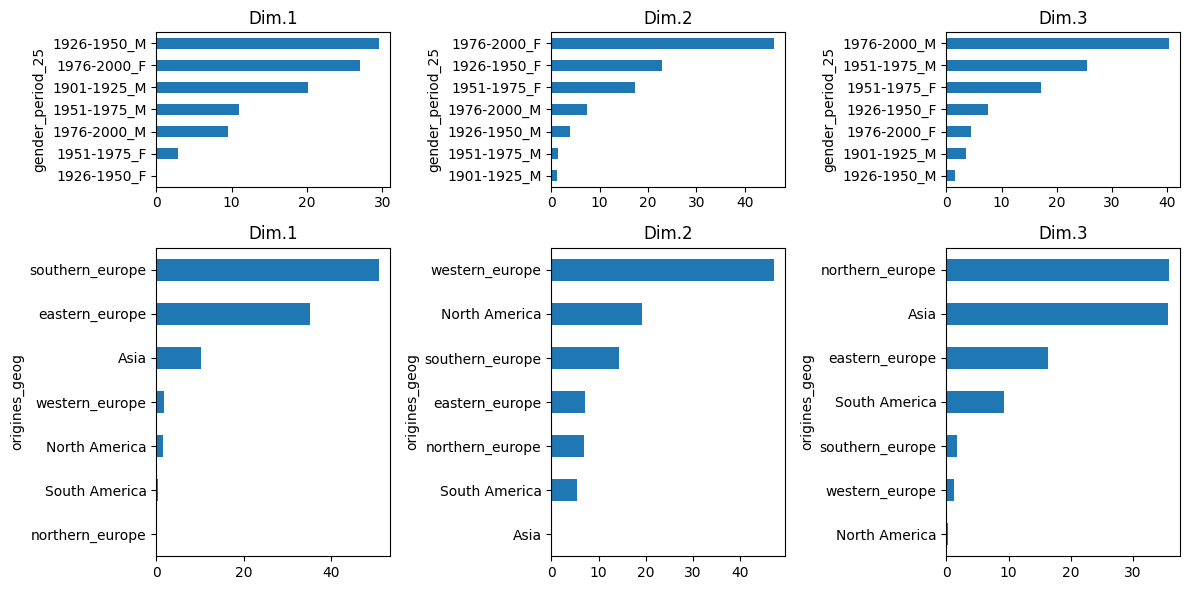

In [42]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6),
                          gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()


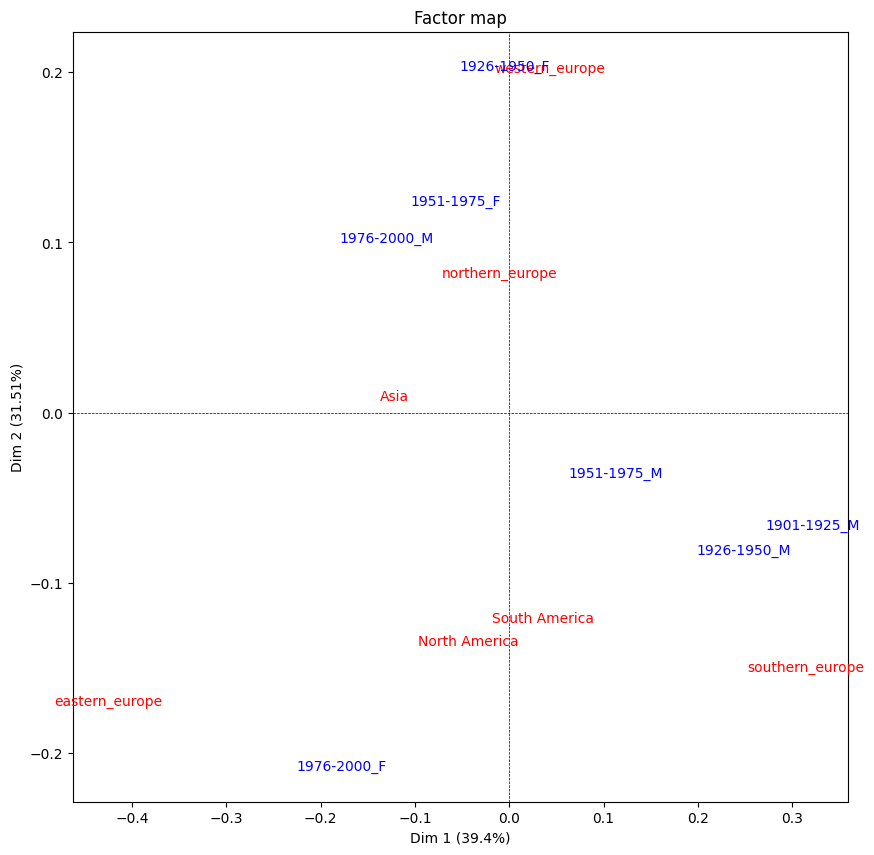

In [43]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))

## Représenter l'autre plan factoriel

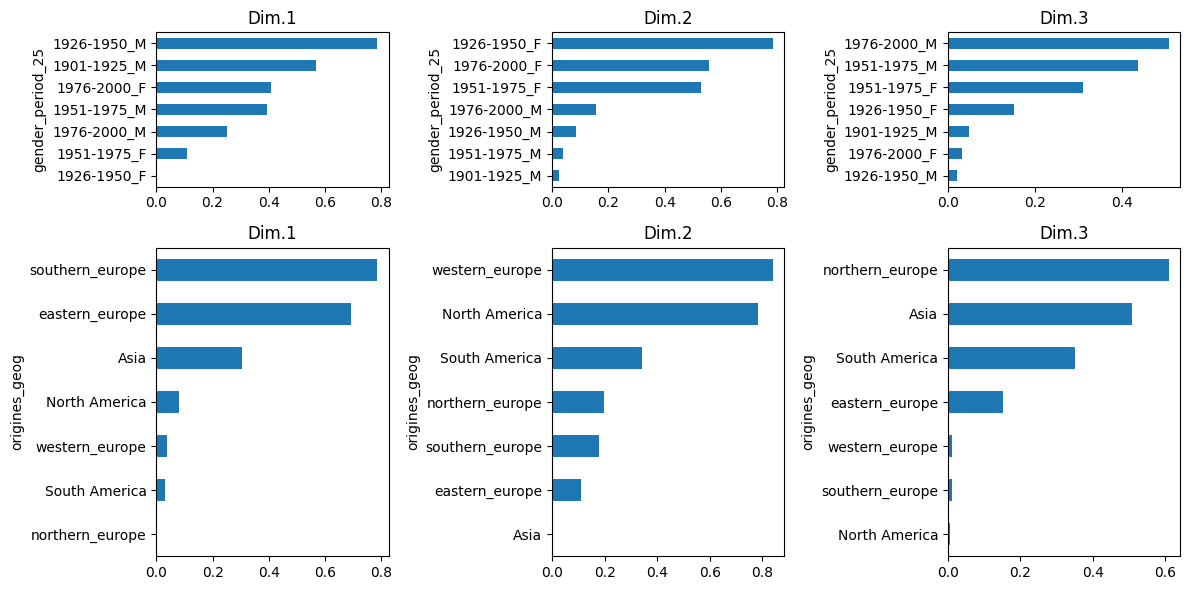

In [44]:
### Informations sur les cosinus carrés. Ces valeurs expriment
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6),
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

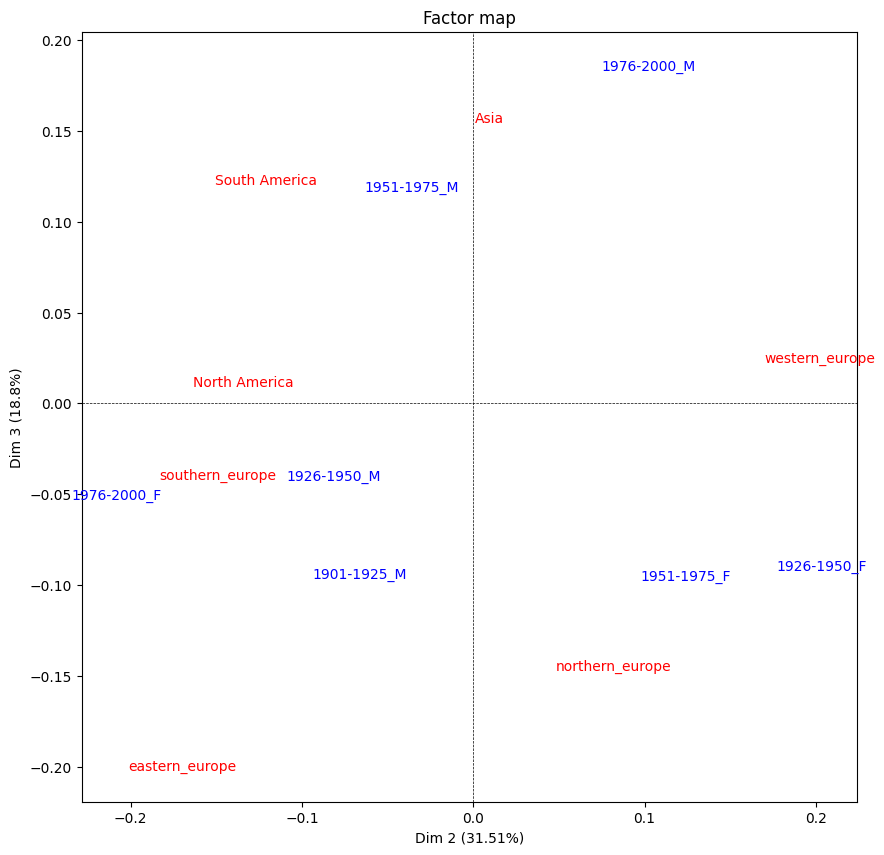

In [45]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

**Commentaire:**

